In [ ]:
%matplotlib inline
import pymc3 as pm
import numpy as np
import pandas as pd
import theano

from scipy import stats
from sklearn.metrics import mean_squared_error
import math

import matplotlib.pyplot as plt
import arviz as az

import seaborn as sns
import warnings
warnings.filterwarnings('ignore')


WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [ ]:
d = pd.read_csv('data/foxes.csv', sep=';', header=0)
d.head()

,group,avgfood,groupsize,area,weight
0,1,0.37,2,1.09,5.02
1,1,0.37,2,1.09,2.84
2,2,0.53,2,2.05,5.33
3,2,0.53,2,2.05,6.07
4,3,0.49,2,2.12,5.85


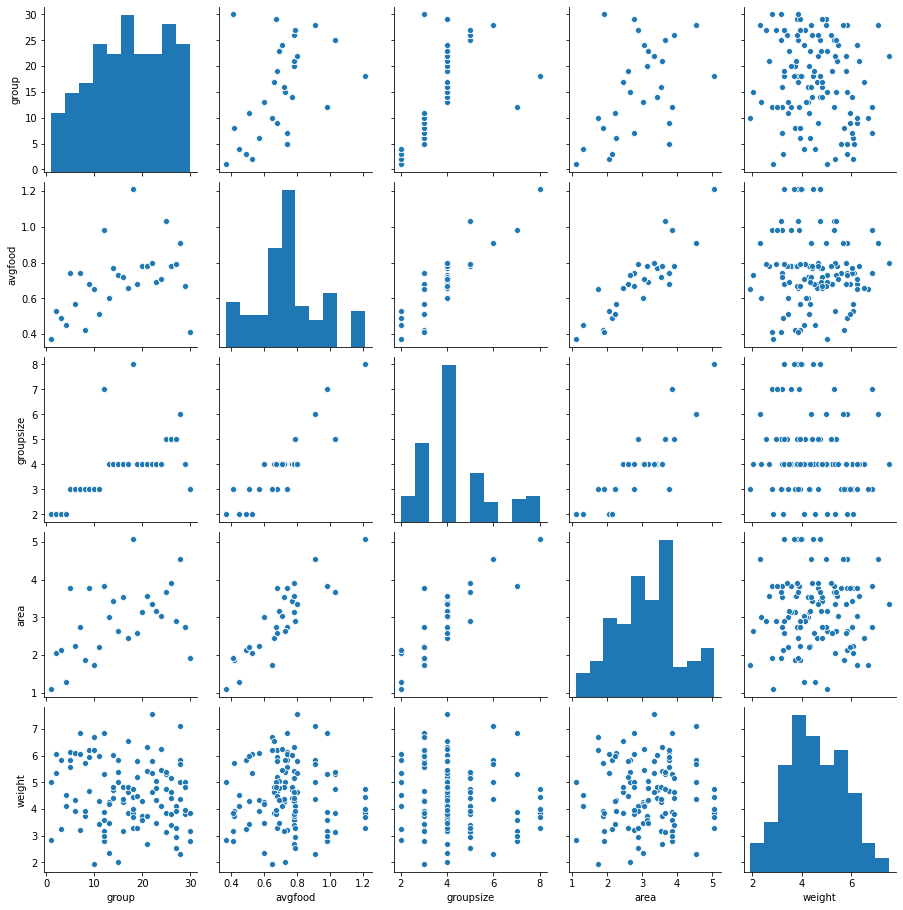

In [ ]:
sns.pairplot(d)

In [ ]:
d.dtypes

group          int64
avgfood      float64
groupsize      int64
area         float64
weight       float64
dtype: object

In [ ]:
d.describe()

,group,avgfood,groupsize,area,weight
count,116.000000,116.000000,116.000000,116.000000,116.000000
mean,17.206897,0.751724,4.344828,3.169138,4.529655
std,8.002736,0.198316,1.538511,0.928354,1.184023
min,1.000000,0.370000,2.000000,1.090000,1.920000
25%,11.750000,0.660000,3.000000,2.590000,3.720000
50%,18.000000,0.735000,4.000000,3.130000,4.420000
75%,24.000000,0.800000,5.000000,3.772500,5.375000
max,30.000000,1.210000,8.000000,5.070000,7.550000


### Excercise 1

In [ ]:
# with pm.Model() as model_ex1:
#     area = pm.Data('area', d.area.to_numpy())
#     avgfood = pm.Data('avgfood', d.avgfood.to_numpy())
#     groupsize = pm.Data('groupsize', d.groupsize.to_numpy())
#     weight = pm.Data('weight', d.weight.to_numpy())
    
#     β_area = pm.Normal("β_area", mu=0, sd=5)    
#     α_food = pm.Normal("α_food", mu=1, sd=1)
#     β_food = pm.Normal("β_food", mu= α_food + β_area * area, sd=1, observed=avgfood)
    
#     σ_weight = pm.Uniform("σ_weight", lower=0, upper=10)
#     μ = groupsize + β_food * avgfood
#     y_weight = pm.Normal('y_weight', mu=μ, sd=σ_weight, observed=weight)
    
#     prior = pm.sample_prior_predictive()
#     trace = pm.sample(draws=1000, tune=1000)
#     posterior = pm.sample_posterior_predictive(trace)

In [ ]:
from sklearn import preprocessing
d[['avgfood','groupsize','area','weight']] = preprocessing.scale(d[['avgfood','groupsize','area','weight']])
d.head()

,group,avgfood,groupsize,area,weight
0,1,-1.933180,-1.530701,-2.249313,0.415931
1,1,-1.933180,-1.530701,-2.249313,-1.433238
2,2,-1.122886,-1.530701,-1.210738,0.678887
3,2,-1.122886,-1.530701,-1.210738,1.306586
4,3,-1.325459,-1.530701,-1.135008,1.119973


In [ ]:
with pm.Model() as model_1:
    # Data
    area = pm.Data('area', d['area'].values)
    weight = pm.Data('weight', d['weight'].values)
    
    # Priors
    alpha = pm.Normal('alpha', mu=0, sd=0.2)
    beta = pm.Normal('beta', mu=0, sd=0.5)
    sigma = pm.Uniform('sigma', lower=0, upper=2)
    
    # Regression
    mu = alpha + beta * area
    weight_hat = pm.Normal('weight_hat', mu=mu, sd=sigma, observed=weight)
    
    # Prior sampling, trace definition and posterior sampling
    prior = pm.sample_prior_predictive(samples = 100)
    posterior_1 = pm.sample()
    posterior_pred_1 = pm.sample_posterior_predictive(posterior_1)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, beta, alpha]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.


In [ ]:
az.summary(posterior_1, credible_interval=.89).round(2)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
alpha,-0.00,0.09,-0.16,0.16,0.0,0.0,5298.0,1838.0,5284.0,2645.0,1.0
beta,0.02,0.10,-0.16,0.19,0.0,0.0,4545.0,1751.0,4582.0,2660.0,1.0
sigma,1.02,0.07,0.90,1.15,0.0,0.0,4840.0,4770.0,4844.0,2462.0,1.0


[]

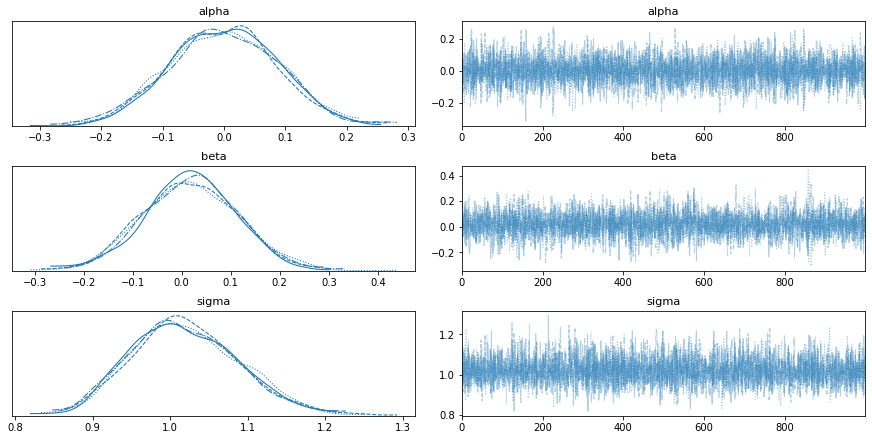

In [ ]:
pm.traceplot(posterior_1)
plt.plot()

##### Sample the priors

In [ ]:
df = pd.DataFrame()
df = df.assign(alpha = pd.Series(prior['alpha']),
               sigma = pd.Series(prior['sigma']),
               beta = pd.Series(prior['beta']))
df.shape

(100, 3)

In [ ]:
df.head()

,alpha,sigma,beta
0,0.107710,0.085365,0.553279
1,0.035864,1.980979,-0.790674
2,0.197607,1.702324,0.500732
3,0.465106,0.064888,-0.173277
4,0.205529,0.869380,0.311648


In [ ]:
priors = pd.DataFrame()
for i in range(df.shape[0]):
    priors['prior_'+str(i)] = df.loc[i,'alpha'] + df.loc[i, 'beta'] * d['area']

In [ ]:
priors.shape

(116, 100)

In [ ]:
aux = pd.concat([d.area, priors], axis=1)
aux.head()

,area,prior_0,prior_1,prior_2,prior_3,prior_4,prior_5,prior_6,prior_7,prior_8,...,prior_90,prior_91,prior_92,prior_93,prior_94,prior_95,prior_96,prior_97,prior_98,prior_99
0,-2.249313,-1.136787,1.814337,-0.928696,0.854861,-0.495465,0.045927,-0.583058,2.403957,2.262407,...,-0.153859,0.764031,-0.487111,1.702976,-2.334936,-4.119669,0.199807,1.269628,0.692139,0.425674
1,-2.249313,-1.136787,1.814337,-0.928696,0.854861,-0.495465,0.045927,-0.583058,2.403957,2.262407,...,-0.153859,0.764031,-0.487111,1.702976,-2.334936,-4.119669,0.199807,1.269628,0.692139,0.425674
2,-1.210738,-0.562166,0.993163,-0.408648,0.674900,-0.171795,0.137728,-0.379597,1.395791,1.374996,...,-0.050885,0.340388,-0.141777,1.017772,-1.432828,-2.242141,0.155683,0.704058,0.392128,0.493694
3,-1.210738,-0.562166,0.993163,-0.408648,0.674900,-0.171795,0.137728,-0.379597,1.395791,1.374996,...,-0.050885,0.340388,-0.141777,1.017772,-1.432828,-2.242141,0.155683,0.704058,0.392128,0.493694
4,-1.135008,-0.520266,0.933286,-0.370728,0.661777,-0.148194,0.144422,-0.364761,1.322279,1.310288,...,-0.043376,0.309498,-0.116597,0.967809,-1.367049,-2.105238,0.152466,0.662819,0.370253,0.498654


In [ ]:
aux_plot = aux.melt(id_vars=['area'], value_vars=list(aux.columns)[1:],
                    var_name='prior', value_name='weight')
aux_plot.shape

(11600, 3)

In [ ]:
aux_plot

,area,prior,weight
0,-2.249313,prior_0,-1.136787
1,-2.249313,prior_0,-1.136787
2,-1.210738,prior_0,-0.562166
3,-1.210738,prior_0,-0.562166
4,-1.135008,prior_0,-0.520266
...,...,...,...
11595,-0.453444,prior_99,0.543292
11596,-0.453444,prior_99,0.543292
11597,-1.362197,prior_99,0.483775
11598,-1.362197,prior_99,0.483775


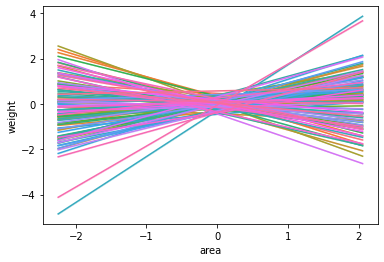

In [ ]:
sns.lineplot(x='area', y='weight', data=aux_plot, hue='prior', legend=False)

### Excercise 2

In [ ]:
with pm.Model() as model_2:
    # Data
    avgfood = pm.Data('avgfood', d['avgfood'].values)
    weight = pm.Data('weight', d['weight'].values)
    
    # Priors
    alpha = pm.Normal('alpha', mu=0, sd=0.2)
    beta = pm.Normal('beta', mu=0, sd=0.5)
    sigma = pm.Uniform('sigma', lower=0, upper=2)
    
    # Regression
    mu = alpha + beta * avgfood
    weight_hat = pm.Normal('weight_hat', mu=mu, sd=sigma, observed=weight)
    
    # Prior sampling, trace definition and posterior sampling
    prior = pm.sample_prior_predictive(samples = 100)
    trace_2 = pm.sample()
    posterior_2 = pm.sample_posterior_predictive(trace_2)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, beta, alpha]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.


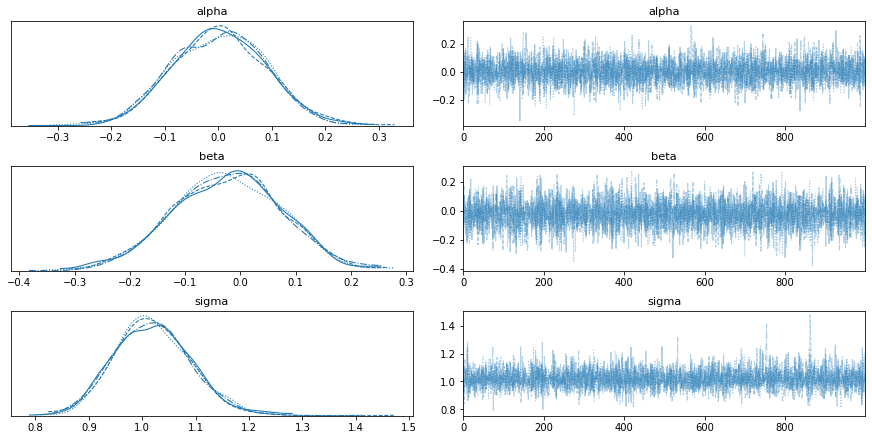

In [ ]:
pm.traceplot(trace_2)
plt.show()

In [ ]:
az.summary(trace_2, credible_interval=0.89)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
alpha,0.002,0.087,-0.165,0.151,0.001,0.001,5023.0,2104.0,5037.0,3003.0,1.0
beta,-0.023,0.097,-0.200,0.159,0.001,0.002,5018.0,1990.0,5016.0,2874.0,1.0
sigma,1.020,0.071,0.892,1.153,0.001,0.001,4876.0,4657.0,5175.0,2630.0,1.0


### Excercise 3

In [ ]:
with pm.Model() as model_3:
    # Data
    avgfood = pm.Data('avgfood', d['avgfood'].values)
    groupsize = pm.Data('groupsize', d['groupsize'].values)
    weight = pm.Data('weight', d['weight'].values)
    
    # Priors
    alpha = pm.Normal('alpha', mu=0, sd=0.2)
    beta_food = pm.Normal('beta_food', mu=0, sd=0.5)
    beta_gsize = pm.Normal('beta_gsize', mu=0, sd=0.5)
    sigma = pm.Uniform('sigma', lower=0, upper=2)
    
    # Regression
    mu = alpha + beta_food * avgfood + beta_gsize * groupsize
    weight_hat = pm.Normal('weight_hat', mu=mu, sd=sigma, observed=weight)
    
    # Prior sampling, trace definition and posterior sampling
    prior3 = pm.sample_prior_predictive(samples = 100)
    trace_3 = pm.sample()
    posterior_3 = pm.sample_posterior_predictive(trace_3)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, beta_gsize, beta_food, alpha]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2 seconds.


In [ ]:
az.summary(trace_3, credible_interval=0.89)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
alpha,0.000,0.081,-0.148,0.155,0.002,0.001,2343.0,1665.0,2361.0,2541.0,1.0
beta_food,0.475,0.182,0.131,0.816,0.003,0.002,2736.0,2668.0,2730.0,2483.0,1.0
beta_gsize,-0.570,0.183,-0.901,-0.206,0.004,0.003,2667.0,2607.0,2669.0,2435.0,1.0
sigma,0.971,0.067,0.852,1.100,0.001,0.001,2695.0,2668.0,2702.0,1842.0,1.0


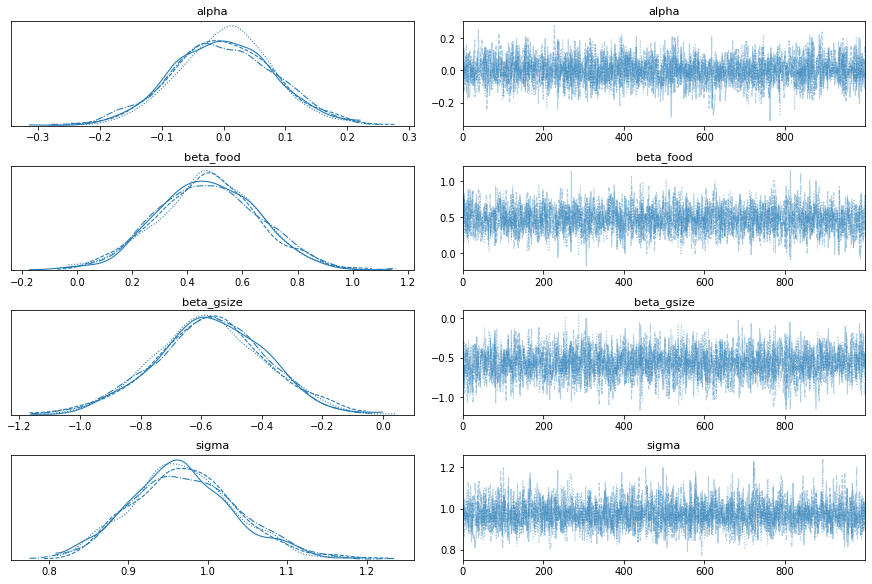

In [ ]:
pm.traceplot(trace_3)
plt.show()

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f55feba4ed0>],
      dtype=object)

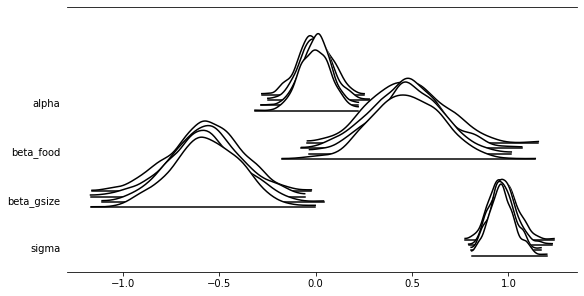

In [ ]:
az.plot_forest(trace_3, kind='ridgeplot', colors='white', figsize=(8,4))

## Comparison

In [ ]:
pm.compare({"model 1": posterior_1, "model 2": trace_2, "model 3": trace_3}, ic="waic")

,rank,waic,p_waic,d_waic,weight,se,dse,warning,waic_scale
model 3,0,-162.271,3.41034,0,0.889964,6.54145,0,False,log
model 2,1,-167.307,2.38673,5.03567,0.050477,6.52815,3.09874,False,log
model 1,2,-167.333,2.52345,5.06191,0.0595592,7.52376,3.20324,False,log
